# install dependency 


In [3]:
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
import tensorflow_io as tfio 

# 2) building data loading function

In [4]:
BASE = os.path.join("data")
one_file = os.path.join(BASE,"Parsed_Capuchinbird_Clips")
zero_file = os.path.join(BASE,"Parsed_Not_Capuchinbird_Clips")

In [5]:
ex1 = os.path.join(one_file,"XC3776-0.wav")
ex0 = os.path.join(zero_file, "afternoon-birds-song-in-forest-0.wav")

### building fucntion to laod the data

In [6]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
file_contents = tf.io.read_file(ex1)
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)

2024-09-20 22:27:58.405060: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-20 22:27:58.405083: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-20 22:27:58.405090: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-20 22:27:58.405127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-20 22:27:58.405141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
print(wav)

tf.Tensor(
[[-0.1289978 ]
 [-0.15133667]
 [-0.14691162]
 ...
 [ 0.11514282]
 [ 0.10748291]
 [ 0.1100769 ]], shape=(132300, 1), dtype=float32)


In [9]:
import librosa

#function to sample the audio file
def load_wav_16k_mono(filename):
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    return wav

In [10]:
# ploating the wave
wave = load_wav_16k_mono(ex1)
nwave = load_wav_16k_mono(ex0)


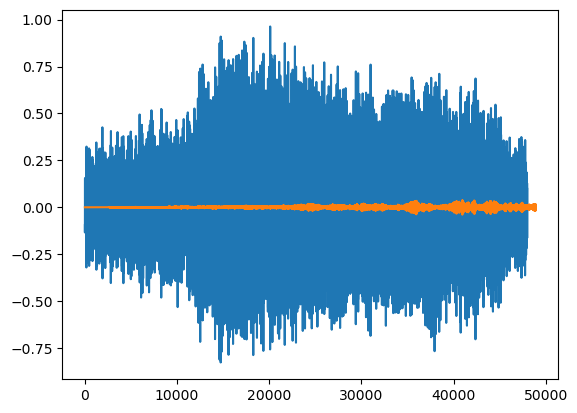

In [11]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## creating a tensorflow dataset

In [12]:
#defining the dataset path
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NOS = os.path.join('data','Parsed_Not_Capuchinbird_Clips')


In [13]:
#creating tensorflow dataset
pos = tf.data.Dataset.list_files(POS+'/*.wav')
nos = tf.data.Dataset.list_files(NOS+'/*.wav')

In [14]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC216010-1.wav'

In [15]:
# adding labels and positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((nos, tf.data.Dataset.from_tensor_slices(tf.ones(len(nos)))))
data = positives.concatenate(negatives)

In [16]:
positives.as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC178168-4.wav', 1.0)

In [17]:
negatives.as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/spooky-owl-sound-effect-0.wav', 1.0)

## 4) determining each call

In [18]:
# calculating wave cycle length
lengths = []
for file in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file ))
    lengths.append(len(tensor_wave))

In [19]:
cycle_value = tf.math.reduce_mean(lengths)

In [20]:
print(f"the average call is of {cycle_value/16000} seconds.")

the average call is of 3.38475 seconds.


In [21]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [22]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

## function to convert to spectrogram

In [29]:
def preprocess(file_path, label):
    # Load the audio waveform as a 1D tensor
    wav = load_wav_16k_mono(file_path)
    
    # Truncate the waveform if it's longer than 48000 samples
    wav = wav[:48000]

    # Get the current length of the waveform
    wav_length = tf.shape(wav)[0]

    # Calculate the padding needed to make the waveform 48000 samples long
    padding_needed = 48000 - wav_length

    # If padding is needed, create a tensor of zeros and concatenate to the wav
    zero_padding = tf.zeros([padding_needed], dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], axis=0)

    # Compute the Short-Time Fourier Transform (STFT) of the waveform
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)

    # Take the absolute value of the spectrogram to get the magnitude
    spectrogram = tf.abs(spectrogram)

    # Expand dimensions to add a channel dimension (for use in CNNs)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    return spectrogram, label

### 5.1) testing out the function and visualising the spectrogram

In [30]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [31]:
spectrogram, label = preprocess(filepath, label)

In [32]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[2.6408978e-02],
        [1.2891688e-02],
        [2.7056193e-02],
        ...,
        [3.1414489e-05],
        [1.0875813e-05],
        [1.8626451e-06]],

       [[4.2704478e-02],
        [2.5926866e-02],
        [4.1149914e-02],
        ...,
        [4.1525341e-06],
        [1.7699254e-05],
        [1.8086284e-06]],

       [[6.2271260e-02],
        [5.6106769e-02],
        [7.4629098e-02],
        ...,
        [6.2060120e-05],
        [1.6670692e-05],
        [2.0502135e-05]],

       ...,

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000

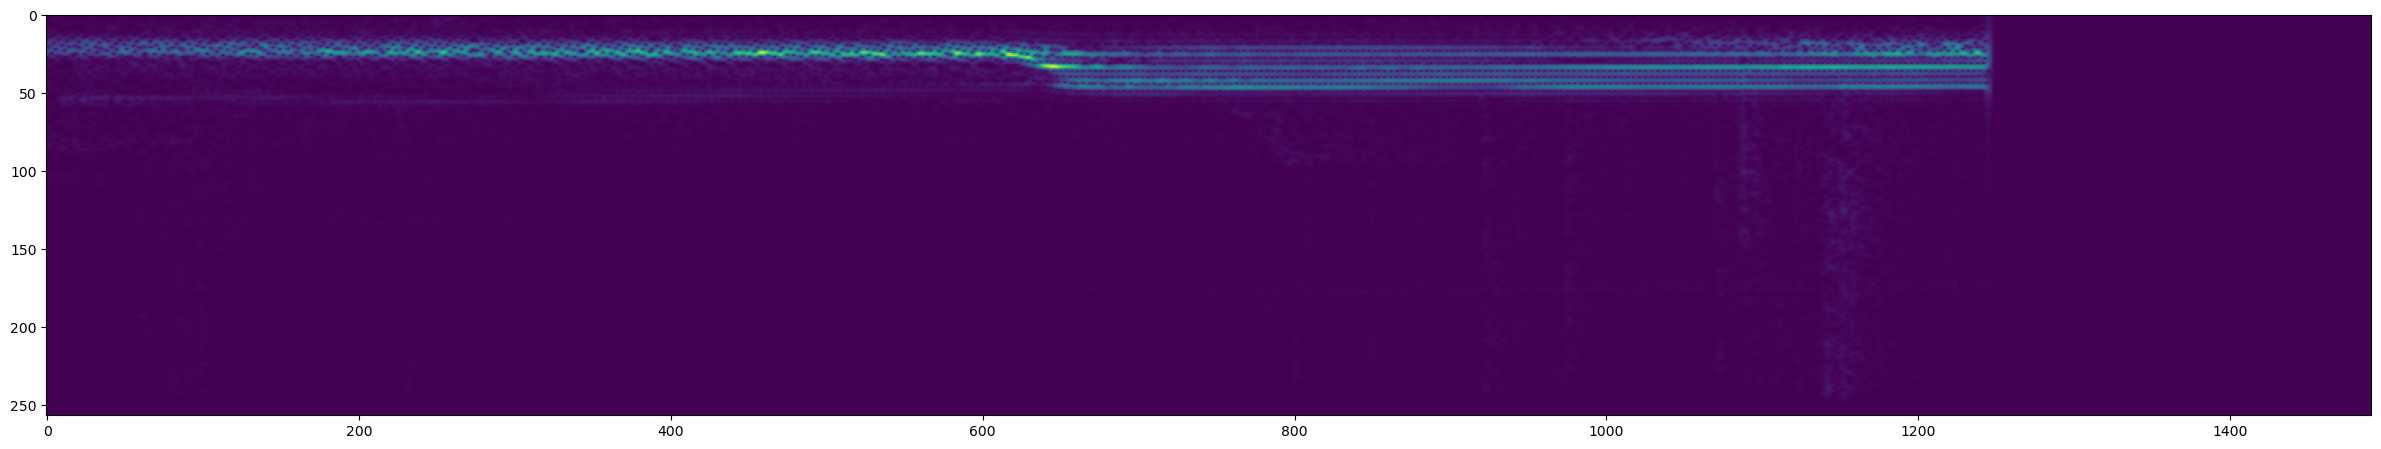

In [33]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6)creating training and testing prtition

### 6.1) creating tensorflow data pipeline

In [38]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=10000)
data = data.batch(16)
data = data.prefetch(8)

TypeError: in user code:

    File "/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_5916/2133480935.py", line 3, in preprocess  *
        wav = load_wav_16k_mono(file_path)
    File "/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_5916/274979017.py", line 5, in load_wav_16k_mono  *
        wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/audio.py", line 176, in load  *
        y, sr_native = __soundfile_load(path, offset, duration, dtype)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/audio.py", line 209, in __soundfile_load  *
        context = sf.SoundFile(path)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/soundfile.py", line 658, in __init__  **
        self._file = self._open(file, mode_int, closefd)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/soundfile.py", line 1212, in _open
        raise TypeError("Invalid file: {0!r}".format(self.name))

    TypeError: Invalid file: <tf.Tensor 'args_0:0' shape=() dtype=string>
